In [8]:
%matplotlib inline
from pyns import Neuroscout
from pathlib import Path
import nilearn.plotting as niplt
import nibabel as nib
import pandas as pd
import seaborn as sns
import json
api = Neuroscout()

In [6]:
RESULTS_DIR = Path('/media/hyperdrive/neuroscout-cli/output/')

In [9]:
cqt = json.load(open('models/cqt_rms.json'))
tonal = json.load(open('models/tonal_rms.json'))

In [12]:
analyses = {'cqt': cqt['Budapest']['movie'],
            'tonal': tonal['Budapest']['movie']}

In [14]:
for k, v in analyses.items():
    analyses[k] = api.analyses.get_analysis(v)

Plot for single subject

In [37]:
def _non_zero_mean(img):
    d = img.get_data()
    return d.mean()

In [38]:
rq1 = nib.load(str(list((RESULTS_DIR / analyses['tonal'].hash_id / 'fitlins' / 'sub-sid000007').glob('*rSq*'))[0]))
rq2 = nib.load(str(list((RESULTS_DIR / analyses['cqt'].hash_id / 'fitlins' / 'sub-sid000007').glob('*rSq*'))[0]))

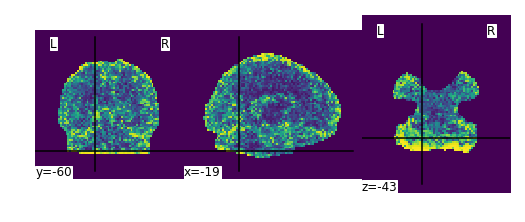

In [39]:
niplt.plot_img(rq1)

In [40]:
_non_zero_mean(rq1)

/home/roberta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


0.09318832305343232

Compute R-squared for all subjects and all analyses

In [41]:
def _get_all_model_maps(analysis, key='rSquare'):
    rsqs = []
    for subject in (RESULTS_DIR / analysis.hash_id / 'fitlins').glob('sub*'):
        rsqs.append(_non_zero_mean(nib.load(str(list(subject.glob(f"*{key}*"))[0]))))
        
    return rsqs

In [42]:
rsquared_all = {}
for n, an in analyses.items():
    rsquared_all[n] = _get_all_model_maps(an)

/home/roberta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


In [43]:
rsquared_all = pd.DataFrame(rsquared_all)

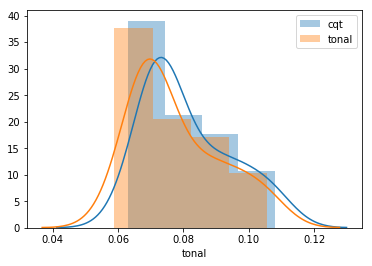

In [50]:
from matplotlib import pyplot as plt
sns.distplot(rsquared_all['cqt'], label='cqt')
sns.distplot(rsquared_all['tonal'], label='tonal')
plt.legend()
plt.show()

Plot spatial

In [51]:
def _get_maps(analysis, key='rSquare'):
    rsqs = []
    for subject in (RESULTS_DIR / analysis.hash_id / 'fitlins').glob('sub*'):
        rsqs.append(nib.load(str(list(subject.glob(f"*{key}*"))[0])))
        
    return rsqs

In [55]:
rsquared_all = {}
for n, an in analyses.items():
    rsquared_all[n] = _get_maps(an)

In [78]:
cqt4d = nib.concat_images(rsquared_all['cqt'], axis=-1)

In [79]:
tonal4d = nib.concat_images(rsquared_all['tonal'], axis=-1)

In [91]:
from nilearn.image import mean_img, math_img

In [85]:
mean_cqt = mean_img(cqt4d)

In [86]:
mean_tonal = mean_img(tonal4d)

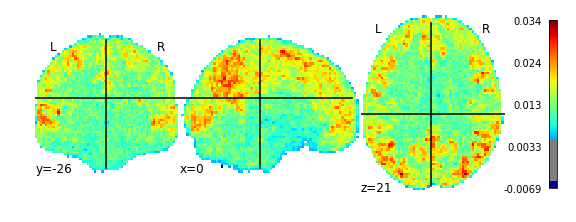

In [110]:
niplt.plot_img(math_img("img2 - img1",
...                     img1=mean_tonal, img2=mean_cqt), 
               cmap='jet', colorbar=True, threshold=.005)